<a href="https://colab.research.google.com/github/HaqTetsuya/ChatbotPerpusBipa/blob/main/IndobertPerpusChatbot_lite_cleaned_refractored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title download dependancy
!pip install transformers torch pandas scikit-learn matplotlib seaborn tqdm deep-translator fuzzywuzzy Levenshtein

In [6]:
# @title import dependency, load drive, and github {"form-width":"20%"}
import json
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Transformers imports
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_scheduler
)

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)

from tqdm.auto import tqdm

!git clone https://github.com/HaqTetsuya/ChatbotPerpusBipa.git
# Mount Google Drive
drive.mount('/content/drive')
FName = "RusdiIntent2" #@param {type:"string"}

# Update MODEL_SAVE_PATH with user input
MODEL_SAVE_PATH = f"/content/drive/MyDrive/{FName}"

fatal: destination path 'ChatbotPerpusBipa' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# @title ---------- Dataset Class ----------#
class IntentDataset(Dataset):
    """Dataset for intent classification with IndoBERT"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Convert dict of tensors to flat tensors
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])

        return item

In [8]:
# @title ---------- Loss Function ----------#
class FocalLoss(nn.Module):
    """Focal Loss implementation for handling class imbalance"""

    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [10]:
# @title ---------- Data Loading Functions ----------#
def load_csv_data(csv_path, label_encoder=None, show_distribution=False):
    """Load intent data from CSV file"""
    print(f"\nLoading data from: {csv_path}")

    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File not found: {csv_path}")

    df = pd.read_csv(csv_path)

    if 'text' not in df.columns or 'intent' not in df.columns:
        raise ValueError("Columns 'text' and 'intent' must exist in CSV")

    # Create or use existing label encoder
    if label_encoder is None:
        label_encoder = LabelEncoder()
        df['intent_encoded'] = label_encoder.fit_transform(df['intent'])
        print(f"New label encoder created from {csv_path}")
    else:
        df['intent_encoded'] = label_encoder.transform(df['intent'])
        print(f"Using existing label encoder")

    intent_classes = label_encoder.classes_

    # Show distribution if requested
    if show_distribution:
        intent_counts = df['intent'].value_counts()
        print("\nIntent distribution:")
        for intent, count in intent_counts.items():
            print(f"  {intent}: {count}")

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.barplot(x=intent_counts.index, y=intent_counts.values, palette="viridis")
        plt.xlabel("Intent")
        plt.ylabel("Count")
        plt.title("Intent Distribution")
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        plt.pie(intent_counts, labels=intent_counts.index, autopct='%1.1f%%',
                colors=sns.color_palette("viridis", len(intent_counts)))
        plt.title("Intent Proportions")
        plt.tight_layout()
        plt.show()

    return df['text'].values, df['intent_encoded'].values, intent_classes, label_encoder

def prepare_data(split_dataset, val_split, train_csv_path="train.csv", val_csv_path="val.csv"):
    """Prepare training and validation data based on split mode"""
    if split_dataset.lower() == "yes":
        all_texts, all_labels, intent_classes, label_encoder = load_csv_data(
            train_csv_path, show_distribution=True)

        train_texts, val_texts, train_labels, val_labels = train_test_split(
            all_texts, all_labels, test_size=val_split, random_state=42, stratify=all_labels
        )

        print(f"\n✅ Dataset split: {len(train_texts)} training and {len(val_texts)} validation samples")
    else:
        train_texts, train_labels, intent_classes, label_encoder = load_csv_data(
            train_csv_path, show_distribution=True)
        val_texts, val_labels, _, _ = load_csv_data(
            val_csv_path, label_encoder=label_encoder, show_distribution=True)

    return train_texts, train_labels, val_texts, val_labels, intent_classes, label_encoder

In [11]:
# @title ---------- Model Setup ----------#
def setup_indobert_for_intent(num_labels):
    """Load IndoBERT model for intent classification"""
    print("Loading IndoBERT model...")
    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
    model = AutoModelForSequenceClassification.from_pretrained(
        "indobenchmark/indobert-base-p2",
        num_labels=num_labels
    )
    print("Model loaded successfully")
    return model, tokenizer


In [12]:
# @title ---------- Training Functions ----------#
def train_intent_classifier(model, tokenizer, train_texts, train_labels, val_texts, val_labels,
                          batch_size=16, epochs=10, learning_rate=2e-5, weight_decay=0.01,
                          save_path=MODEL_SAVE_PATH, use_class_weights=True, patience=3, class_names=None):
    """Train intent classifier with early stopping and validation"""
    # Create dataset and dataloaders
    train_dataset = IntentDataset(train_texts, train_labels, tokenizer)
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Setup device, optimizer, scheduler, and loss function
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Compute class weights if needed
    class_weights = None
    if use_class_weights:
        unique_classes = np.unique(train_labels)
        weights = compute_class_weight(
            class_weight='balanced',
            classes=unique_classes,
            y=train_labels
        )
        class_weights = torch.FloatTensor(weights).to(device)
        print(f"Using class weights: {weights}")

    # Create optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Create scheduler with warmup
    num_training_steps = len(train_dataloader) * epochs
    num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup
    scheduler = get_scheduler("cosine", optimizer=optimizer,
                             num_warmup_steps=num_warmup_steps,
                             num_training_steps=num_training_steps)

    # Create loss function
    loss_fn = FocalLoss(alpha=class_weights, gamma=2.0)
    print("Using Focal Loss with gamma=2.0")

    # Move model to device
    model.to(device)

    # Initialize training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': [],
        'batch_metrics': {
            'iteration': [],
            'loss': [],
            'epoch': [],
            'progress': [],
            'learning_rates': []
        },
        'class_f1': [],
        'class_precision': [],
        'class_recall': []
    }

    # Training loop
    best_val_loss = float('inf')
    counter = 0  # Counter for early stopping

    print(f"Starting training: {epochs} epochs, batch size: {batch_size}, LR: {learning_rate}")

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader),
                          desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)

        for batch_idx, batch in progress_bar:
            try:
                # Move batch to device
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)

                # Forward and backward pass
                optimizer.zero_grad()
                outputs = model(**inputs)
                loss = loss_fn(outputs.logits, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()

                # Update metrics
                train_loss += loss.item()

                # Track batch metrics
                global_iteration = epoch * len(train_dataloader) + batch_idx
                progress = (epoch + (batch_idx / len(train_dataloader))) * 100

                history['batch_metrics']['iteration'].append(global_iteration)
                history['batch_metrics']['loss'].append(loss.item())
                history['batch_metrics']['epoch'].append(epoch)
                history['batch_metrics']['progress'].append(progress)
                history['batch_metrics']['learning_rates'].append(optimizer.param_groups[0]['lr'])

                progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

            except RuntimeError as e:
                if "out of memory" in str(e):
                    print("Warning: Out of memory! Clearing cache...")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

        # Calculate average training loss
        avg_train_loss = train_loss / len(train_dataloader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        val_metrics = validate_model(model, device, val_dataloader, loss_fn, epoch, epochs)

        # Update history with validation metrics
        history['val_loss'].append(val_metrics['avg_val_loss'])
        history['val_accuracy'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
        history['val_precision'].append(val_metrics['precision'])
        history['val_recall'].append(val_metrics['recall'])

        # Update per-class metrics if class names are provided
        if class_names is not None:
            class_f1 = f1_score(val_metrics['all_labels'], val_metrics['all_preds'],
                               average=None, zero_division=0)
            class_precision = precision_score(val_metrics['all_labels'], val_metrics['all_preds'],
                                           average=None, zero_division=0)
            class_recall = recall_score(val_metrics['all_labels'], val_metrics['all_preds'],
                                     average=None, zero_division=0)

            history['class_f1'].append(class_f1.tolist())
            history['class_precision'].append(class_precision.tolist())
            history['class_recall'].append(class_recall.tolist())

            # Generate confusion matrix for this epoch
            plot_confusion_matrix(val_metrics['all_labels'], val_metrics['all_preds'],
                                class_names, epoch, save_path)

        # Print metrics
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {val_metrics['avg_val_loss']:.4f}, Val Accuracy: {val_metrics['accuracy']*100:.2f}%")
        print(f"  Val F1: {val_metrics['f1']:.4f}, Val Precision: {val_metrics['precision']:.4f}, Val Recall: {val_metrics['recall']:.4f}")

        if 'all_labels' in val_metrics and 'all_preds' in val_metrics:
            print(f"\nClass-wise precision/recall/F1 after epoch {epoch+1}:")
            print(classification_report(val_metrics['all_labels'], val_metrics['all_preds'], digits=4))

        # Early stopping check
        if val_metrics['avg_val_loss'] < best_val_loss:
            best_val_loss = val_metrics['avg_val_loss']
            counter = 0  # Reset counter

            # Save best model
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            print(f"Saving best model to {save_path}")
            model.save_pretrained(save_path)
            tokenizer.save_pretrained(save_path)

            # Save classification report
            report = classification_report(val_metrics['all_labels'], val_metrics['all_preds'], output_dict=True)
            with open(os.path.join(save_path, "classification_report.json"), 'w') as f:
                json.dump(report, f, indent=4)
        else:
            counter += 1
            print(f"Validation loss not improving. Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    print(f"Training complete! Best model saved at {save_path}")

    # Generate visualizations
    create_training_visualizations(history, save_path, class_names)
    static_plot_training_results(history, save_path)
    # Save history
    save_training_history(history, save_path)

    return model, history

def validate_model(model, device, dataloader, loss_fn, epoch, epochs):
    """Validate model on validation dataset"""
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()

            # Calculate accuracy
            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Collect predictions and labels for metrics
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    # Calculate metrics
    avg_val_loss = val_loss / len(dataloader)
    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    return {
        'avg_val_loss': avg_val_loss,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'all_preds': all_preds,
        'all_labels': all_labels
    }

In [13]:
# @title ---------- Visualization Functions ----------#
def create_training_visualizations(history, save_path, class_names=None):
    """Create visualizations for training history"""
    # Create directories
    os.makedirs(os.path.join(save_path, "class_metrics"), exist_ok=True)

    # Plot learning rate if available
    if 'batch_metrics' in history and 'learning_rates' in history['batch_metrics']:
        plt.figure(figsize=(12, 6))
        plt.plot(history['batch_metrics']['iteration'], history['batch_metrics']['learning_rates'])
        plt.title('Learning Rate Schedule')
        plt.xlabel('Iteration')
        plt.ylabel('Learning Rate')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, "learning_rate_schedule.png"))
        plt.close()

    # Plot per-class F1 scores if available
    if 'class_f1' in history and class_names is not None:
        plt.figure(figsize=(12, 8))

        epochs = len(history['class_f1'])
        x_epochs = list(range(1, epochs + 1))

        for i, class_name in enumerate(class_names):
            class_f1 = [history['class_f1'][epoch][i] for epoch in range(epochs)]
            plt.plot(x_epochs, class_f1, marker='o', label=f'{class_name}')

        plt.title('F1 Score per Class')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, "class_metrics", "f1_per_class.png"))
        plt.close()

def static_plot_training_results(history, save_path):
    """Plot and save training metrics using matplotlib (static)"""
    plt.figure(figsize=(15, 10))

    # Plot 1: Loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o', color='green')
    plt.title('Akurasi selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 3: F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(history['val_f1'], label='Validation F1', marker='o', color='purple')
    plt.title('F1 Score selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    # Plot 4: Precision & Recall
    plt.subplot(2, 2, 4)
    plt.plot(history['val_precision'], label='Validation Precision', marker='o', color='orange')
    plt.plot(history['val_recall'], label='Validation Recall', marker='o', color='brown')
    plt.title('Precision & Recall selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(save_path, "training_metrics.png"))
    plt.close()

def plot_confusion_matrix(all_labels, all_preds, class_names, epoch, save_path):
    """Plot and save confusion matrix for an epoch"""
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f'Confusion Matrix - Epoch {epoch+1}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

    # Save the confusion matrix
    cm_dir = os.path.join(save_path, "confusion_matrices")
    os.makedirs(cm_dir, exist_ok=True)
    plt.savefig(os.path.join(cm_dir, f"cm_epoch_{epoch+1}.png"))
    plt.close()

def save_training_history(history, save_path):
    """Save training history to JSON file"""
    # Convert numpy arrays to lists for JSON serialization
    processed_history = {}

    for key, value in history.items():
        if isinstance(value, dict):
            processed_history[key] = {}
            for subkey, subvalue in value.items():
                processed_history[key][subkey] = convert_to_serializable(subvalue)
        else:
            processed_history[key] = convert_to_serializable(value)

    # Save history
    with open(os.path.join(save_path, "training_history.json"), 'w') as f:
        json.dump(processed_history, f, indent=4)

    print(f"Training history saved to {os.path.join(save_path, 'training_history.json')}")

def convert_to_serializable(value):
    """Convert numpy arrays and other non-serializable types to JSON-compatible types"""
    if isinstance(value, np.ndarray):
        return value.tolist()
    elif isinstance(value, list):
        if value and isinstance(value[0], np.ndarray):
            return [item.tolist() if isinstance(item, np.ndarray) else item for item in value]
        else:
            return value
    else:
        return value


In [14]:
# @title ---------- Evaluation Functions ----------#
def evaluate_model(model, tokenizer, val_texts, val_labels, intent_classes, save_path):
    """Evaluate model and generate reports"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    # Prepare dataset and dataloader
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=16)

    all_preds = []
    all_labels = []

    # Evaluation loop
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluating Model"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Generate classification report
    report = classification_report(all_labels, all_preds,
                                 target_names=intent_classes,
                                 output_dict=True)

    # Create dataframe for visualization
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.round(3)

    # Save classification metrics as CSV
    report_df.to_csv(os.path.join(save_path, "classification_report.csv"))

    # Create confusion matrix visualization
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=intent_classes, yticklabels=intent_classes)
    plt.title('Confusion Matrix - Final Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "final_confusion_matrix.png"))
    plt.close()

    # Create classification report heatmap
    class_df = report_df.loc[intent_classes]
    metrics = ['precision', 'recall', 'f1-score']

    plt.figure(figsize=(12, len(intent_classes)*0.5 + 3))
    sns.heatmap(class_df[metrics], annot=True, cmap='YlGnBu', fmt='.3f',
               yticklabels=intent_classes, cbar=True)
    plt.title('Performance Metrics by Intent Class')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "class_performance_metrics.png"))
    plt.close()

    # Print report summary
    print("\nModel Evaluation Report:")
    print(f"Overall Accuracy: {report['accuracy']:.4f}")
    print(f"Macro F1-score: {report['macro avg']['f1-score']:.4f}")
    print(f"Weighted F1-score: {report['weighted avg']['f1-score']:.4f}")

    return report, cm

In [15]:
# @title ---------- OOD Detection ----------#
def calibrate_ood_detection(model, tokenizer, dataloader, temperature=1.0, percentile=70, margin=0.1):
    """Calibrate thresholds for out-of-distribution detection"""
    device = next(model.parameters()).device
    model.eval()

    # For Energy method and MSP method
    energy_scores = []
    msp_scores = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calibrating OOD detection"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            logits = outputs.logits

            # Energy score (higher values for OOD)
            energy = -temperature * torch.logsumexp(logits / temperature, dim=1)
            energy_scores.extend(energy.cpu().numpy())

            # MSP score (lower values for OOD)
            softmax_probs = F.softmax(logits, dim=1)
            max_probs, _ = torch.max(softmax_probs, dim=1)
            msp_scores.extend(max_probs.cpu().numpy())

    # Calculate thresholds with margin
    base_energy_threshold = np.percentile(energy_scores, percentile)
    energy_threshold = base_energy_threshold * (1 + margin)

    base_msp_threshold = np.percentile(msp_scores, 100 - percentile)
    msp_threshold = base_msp_threshold * (1 - margin)

    return {
        "energy_threshold": float(energy_threshold),
        "msp_threshold": float(msp_threshold)
    }

def save_ood_thresholds(thresholds, save_path):
    """Save OOD detection thresholds to file"""
    threshold_file = os.path.join(save_path, "ood_thresholds.json")
    with open(threshold_file, 'w') as f:
        json.dump(thresholds, f, indent=4)
    print(f"OOD thresholds saved at {threshold_file}")
    return threshold_file

def load_ood_thresholds(model_path):
    """Load OOD detection thresholds from file"""
    try:
        with open(os.path.join(model_path, "ood_thresholds.json"), 'r') as f:
            thresholds = json.load(f)
            return thresholds
    except FileNotFoundError:
        try:
            with open(os.path.join(model_path, "ood_threshold.json"), 'r') as f:
                threshold_data = json.load(f)
                return {
                    "energy_threshold": threshold_data["energy_threshold"],
                    "msp_threshold": None
                }
        except FileNotFoundError:
            print("Warning: OOD threshold files not found. Using default thresholds.")
            return {
                "energy_threshold": 0.0,
                "msp_threshold": 0.5
            }

In [16]:
# @title ---------- Main Pipeline ----------#
def run_intent_classification_pipeline(
    use_drive=True,
    percentile=95,
    split_dataset="no",
    val_split=0.2,
    batch_size=16,
    epochs=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    patience=3,
    train_csv_path="train.csv",
    val_csv_path="val.csv"
):
    """Run full intent classification pipeline"""
    # Create save directory
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

    # Prepare data
    train_texts, train_labels, val_texts, val_labels, intent_classes, label_encoder = prepare_data(
        split_dataset, val_split, train_csv_path, val_csv_path)

    num_labels = len(intent_classes)
    print(f"Number of intents: {num_labels}")
    print(f"Supported intents: {', '.join(intent_classes)}")

    # Setup model
    model, tokenizer = setup_indobert_for_intent(num_labels)

    # Train model
    model, history = train_intent_classifier(
        model,
        tokenizer,
        train_texts,
        train_labels,
        val_texts,
        val_labels,
        class_names=intent_classes,
        batch_size=batch_size,
        epochs=epochs,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        patience=patience
    )

    # Prepare validation dataloader for OOD calibration
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=16)

    # Calibrate OOD detection
    thresholds = calibrate_ood_detection(model, tokenizer, val_dataloader, percentile=percentile)
    save_ood_thresholds(thresholds, MODEL_SAVE_PATH)
    print(f"OOD detection thresholds: Energy={thresholds['energy_threshold']:.4f}, MSP={thresholds['msp_threshold']:.4f}")

    # Evaluate model
    report, cm = evaluate_model(model, tokenizer, val_texts, val_labels, intent_classes, MODEL_SAVE_PATH)

    # Save intent classes & label encoder
    with open(f"{MODEL_SAVE_PATH}/intent_classes.pkl", "wb") as f:
        pickle.dump(intent_classes, f)

    with open(f"{MODEL_SAVE_PATH}/label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)

    print(f"\n✅ Model successfully trained and saved at {MODEL_SAVE_PATH}")
    print(f"Visualizations saved at {MODEL_SAVE_PATH}")

    return model, tokenizer, intent_classes, label_encoder


Loading data from: train.csv
New label encoder created from train.csv

Intent distribution:
  keanggotaan: 869
  fasilitas: 855
  cari_buku: 829
  jam_layanan: 803
  goodbye: 735
  denied: 732
  confirm: 665
  greeting: 664


<ipython-input-10-7e418f7d4776>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=intent_counts.index, y=intent_counts.values, palette="viridis")


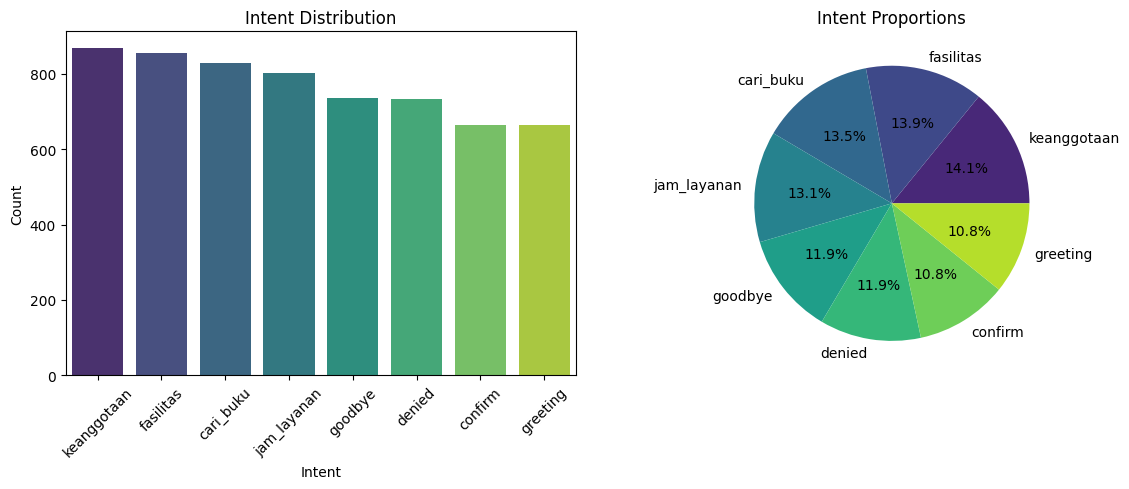


✅ Dataset split: 4921 training and 1231 validation samples
Number of intents: 8
Supported intents: cari_buku, confirm, denied, fasilitas, goodbye, greeting, jam_layanan, keanggotaan
Loading IndoBERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully
Using device: cuda
Using class weights: [0.92779035 1.15625    1.04970137 0.89930556 1.04613095 1.1584275
 0.95813863 0.88507194]
Using Focal Loss with gamma=2.0
Starting training: 12 epochs, batch size: 32, LR: 2.5e-05


Epoch 1/12 [Training]:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 1/12 [Validation]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 1/12:
  Train Loss: 0.6553
  Val Loss: 0.0399, Val Accuracy: 97.89%
  Val F1: 0.9790, Val Precision: 0.9798, Val Recall: 0.9789

Class-wise precision/recall/F1 after epoch 1:
              precision    recall  f1-score   support

           0     1.0000    0.9880    0.9939       166
           1     0.9764    0.9323    0.9538       133
           2     0.9930    0.9726    0.9827       146
           3     0.9553    1.0000    0.9771       171
           4     0.9862    0.9728    0.9795       147
           5     0.9167    0.9925    0.9531       133
           6     1.0000    0.9876    0.9938       161
           7     1.0000    0.9770    0.9884       174

    accuracy                         0.9789      1231
   macro avg     0.9784    0.9778    0.9778      1231
weighted avg     0.9798    0.9789    0.9790      1231

Saving best model to /content/drive/MyDrive/RusdiIntent2


Epoch 2/12 [Training]:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 2/12 [Validation]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 2/12:
  Train Loss: 0.0325
  Val Loss: 0.0198, Val Accuracy: 99.19%
  Val F1: 0.9918, Val Precision: 0.9920, Val Recall: 0.9919

Class-wise precision/recall/F1 after epoch 2:
              precision    recall  f1-score   support

           0     1.0000    0.9940    0.9970       166
           1     0.9921    0.9474    0.9692       133
           2     1.0000    0.9863    0.9931       146
           3     0.9942    1.0000    0.9971       171
           4     0.9800    1.0000    0.9899       147
           5     0.9638    1.0000    0.9815       133
           6     1.0000    1.0000    1.0000       161
           7     1.0000    1.0000    1.0000       174

    accuracy                         0.9919      1231
   macro avg     0.9913    0.9910    0.9910      1231
weighted avg     0.9920    0.9919    0.9918      1231

Saving best model to /content/drive/MyDrive/RusdiIntent2


Epoch 3/12 [Training]:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 3/12 [Validation]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 3/12:
  Train Loss: 0.0111
  Val Loss: 0.0218, Val Accuracy: 99.35%
  Val F1: 0.9935, Val Precision: 0.9936, Val Recall: 0.9935

Class-wise precision/recall/F1 after epoch 3:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       166
           1     0.9922    0.9549    0.9732       133
           2     0.9603    0.9932    0.9764       146
           3     1.0000    0.9942    0.9971       171
           4     1.0000    1.0000    1.0000       147
           5     1.0000    1.0000    1.0000       133
           6     1.0000    1.0000    1.0000       161
           7     0.9943    1.0000    0.9971       174

    accuracy                         0.9935      1231
   macro avg     0.9933    0.9928    0.9930      1231
weighted avg     0.9936    0.9935    0.9935      1231

Validation loss not improving. Early stopping counter: 1/3


Epoch 4/12 [Training]:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 4/12 [Validation]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 4/12:
  Train Loss: 0.0070
  Val Loss: 0.0132, Val Accuracy: 99.27%
  Val F1: 0.9927, Val Precision: 0.9928, Val Recall: 0.9927

Class-wise precision/recall/F1 after epoch 4:
              precision    recall  f1-score   support

           0     0.9940    1.0000    0.9970       166
           1     0.9922    0.9624    0.9771       133
           2     0.9732    0.9932    0.9831       146
           3     1.0000    0.9883    0.9941       171
           4     1.0000    1.0000    1.0000       147
           5     0.9925    1.0000    0.9963       133
           6     1.0000    0.9938    0.9969       161
           7     0.9886    1.0000    0.9943       174

    accuracy                         0.9927      1231
   macro avg     0.9926    0.9922    0.9923      1231
weighted avg     0.9928    0.9927    0.9927      1231

Saving best model to /content/drive/MyDrive/RusdiIntent2


Epoch 5/12 [Training]:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 5/12 [Validation]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 5/12:
  Train Loss: 0.0019
  Val Loss: 0.0130, Val Accuracy: 99.51%
  Val F1: 0.9951, Val Precision: 0.9951, Val Recall: 0.9951

Class-wise precision/recall/F1 after epoch 5:
              precision    recall  f1-score   support

           0     0.9940    1.0000    0.9970       166
           1     0.9924    0.9774    0.9848       133
           2     0.9932    0.9932    0.9932       146
           3     1.0000    0.9883    0.9941       171
           4     1.0000    1.0000    1.0000       147
           5     0.9852    1.0000    0.9925       133
           6     1.0000    1.0000    1.0000       161
           7     0.9943    1.0000    0.9971       174

    accuracy                         0.9951      1231
   macro avg     0.9949    0.9949    0.9948      1231
weighted avg     0.9951    0.9951    0.9951      1231

Saving best model to /content/drive/MyDrive/RusdiIntent2


Epoch 6/12 [Training]:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 6/12 [Validation]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 6/12:
  Train Loss: 0.0022
  Val Loss: 0.0159, Val Accuracy: 99.51%
  Val F1: 0.9951, Val Precision: 0.9952, Val Recall: 0.9951

Class-wise precision/recall/F1 after epoch 6:
              precision    recall  f1-score   support

           0     1.0000    0.9940    0.9970       166
           1     0.9923    0.9699    0.9810       133
           2     1.0000    0.9932    0.9966       146
           3     0.9942    1.0000    0.9971       171
           4     1.0000    1.0000    1.0000       147
           5     0.9708    1.0000    0.9852       133
           6     1.0000    1.0000    1.0000       161
           7     1.0000    1.0000    1.0000       174

    accuracy                         0.9951      1231
   macro avg     0.9947    0.9946    0.9946      1231
weighted avg     0.9952    0.9951    0.9951      1231

Validation loss not improving. Early stopping counter: 1/3


Epoch 7/12 [Training]:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 7/12 [Validation]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 7/12:
  Train Loss: 0.0013
  Val Loss: 0.0156, Val Accuracy: 99.59%
  Val F1: 0.9959, Val Precision: 0.9960, Val Recall: 0.9959

Class-wise precision/recall/F1 after epoch 7:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       166
           1     0.9924    0.9774    0.9848       133
           2     1.0000    0.9932    0.9966       146
           3     1.0000    0.9942    0.9971       171
           4     1.0000    1.0000    1.0000       147
           5     0.9779    1.0000    0.9888       133
           6     1.0000    1.0000    1.0000       161
           7     0.9943    1.0000    0.9971       174

    accuracy                         0.9959      1231
   macro avg     0.9956    0.9956    0.9956      1231
weighted avg     0.9960    0.9959    0.9959      1231

Validation loss not improving. Early stopping counter: 2/3


Epoch 8/12 [Training]:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 8/12 [Validation]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 8/12:
  Train Loss: 0.0006
  Val Loss: 0.0093, Val Accuracy: 99.59%
  Val F1: 0.9959, Val Precision: 0.9960, Val Recall: 0.9959

Class-wise precision/recall/F1 after epoch 8:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       166
           1     0.9924    0.9850    0.9887       133
           2     0.9864    0.9932    0.9898       146
           3     1.0000    0.9942    0.9971       171
           4     1.0000    1.0000    1.0000       147
           5     0.9925    1.0000    0.9963       133
           6     1.0000    0.9938    0.9969       161
           7     0.9943    1.0000    0.9971       174

    accuracy                         0.9959      1231
   macro avg     0.9957    0.9958    0.9957      1231
weighted avg     0.9960    0.9959    0.9959      1231

Saving best model to /content/drive/MyDrive/RusdiIntent2


Epoch 9/12 [Training]:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 9/12 [Validation]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 9/12:
  Train Loss: 0.0005
  Val Loss: 0.0104, Val Accuracy: 99.59%
  Val F1: 0.9959, Val Precision: 0.9960, Val Recall: 0.9959

Class-wise precision/recall/F1 after epoch 9:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       166
           1     0.9924    0.9850    0.9887       133
           2     0.9932    0.9932    0.9932       146
           3     1.0000    0.9942    0.9971       171
           4     1.0000    1.0000    1.0000       147
           5     0.9852    1.0000    0.9925       133
           6     1.0000    0.9938    0.9969       161
           7     0.9943    1.0000    0.9971       174

    accuracy                         0.9959      1231
   macro avg     0.9956    0.9958    0.9957      1231
weighted avg     0.9960    0.9959    0.9959      1231

Validation loss not improving. Early stopping counter: 1/3


Epoch 10/12 [Training]:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 10/12 [Validation]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 10/12:
  Train Loss: 0.0003
  Val Loss: 0.0102, Val Accuracy: 99.59%
  Val F1: 0.9959, Val Precision: 0.9960, Val Recall: 0.9959

Class-wise precision/recall/F1 after epoch 10:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       166
           1     0.9924    0.9850    0.9887       133
           2     0.9932    0.9932    0.9932       146
           3     1.0000    0.9942    0.9971       171
           4     1.0000    1.0000    1.0000       147
           5     0.9852    1.0000    0.9925       133
           6     1.0000    0.9938    0.9969       161
           7     0.9943    1.0000    0.9971       174

    accuracy                         0.9959      1231
   macro avg     0.9956    0.9958    0.9957      1231
weighted avg     0.9960    0.9959    0.9959      1231

Validation loss not improving. Early stopping counter: 2/3


Epoch 11/12 [Training]:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 11/12 [Validation]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 11/12:
  Train Loss: 0.0003
  Val Loss: 0.0104, Val Accuracy: 99.59%
  Val F1: 0.9959, Val Precision: 0.9960, Val Recall: 0.9959

Class-wise precision/recall/F1 after epoch 11:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       166
           1     0.9924    0.9850    0.9887       133
           2     0.9932    0.9932    0.9932       146
           3     1.0000    0.9942    0.9971       171
           4     1.0000    1.0000    1.0000       147
           5     0.9852    1.0000    0.9925       133
           6     1.0000    0.9938    0.9969       161
           7     0.9943    1.0000    0.9971       174

    accuracy                         0.9959      1231
   macro avg     0.9956    0.9958    0.9957      1231
weighted avg     0.9960    0.9959    0.9959      1231

Validation loss not improving. Early stopping counter: 3/3
Early stopping triggered after 11 epochs
Training complete! Best model saved at /content/drive/MyDrive/Rusd

Calibrating OOD detection:   0%|          | 0/77 [00:00<?, ?it/s]

OOD thresholds saved at /content/drive/MyDrive/RusdiIntent2/ood_thresholds.json
OOD detection thresholds: Energy=-5.5357, MSP=0.8761


Evaluating Model:   0%|          | 0/77 [00:00<?, ?it/s]


Model Evaluation Report:
Overall Accuracy: 0.9959
Macro F1-score: 0.9957
Weighted F1-score: 0.9959

✅ Model successfully trained and saved at /content/drive/MyDrive/RusdiIntent2
Visualizations saved at /content/drive/MyDrive/RusdiIntent2


In [19]:
# Run the pipeline
if __name__ == "__main__":
    model, tokenizer, intent_classes, label_encoder = run_intent_classification_pipeline(
        use_drive=True,
        percentile=90,
        split_dataset="yes",
        val_split=0.20,
        batch_size=32,
        epochs=12,
        learning_rate=2.5e-5,
        weight_decay=0.01,
        patience=3,
        train_csv_path="train.csv",
		val_csv_path="val.csv"
		)

Augmenting 'keanggotaan': 100%|██████████| 125/125 [03:32<00:00,  1.70s/it]



Applying paraphrase model in batches...
  Processing 80 texts for intent 'confirm'
    Added 11 valid paraphrases
Balancing final dataset...

Final dataset statistics:
  cari_buku: 1000 total (125 original + 875 augmented)
  confirm: 1000 total (125 original + 875 augmented)
  denied: 1000 total (125 original + 875 augmented)
  fasilitas: 1000 total (125 original + 875 augmented)
  goodbye: 1000 total (125 original + 875 augmented)
  greeting: 1000 total (125 original + 875 augmented)
  jam_layanan: 1000 total (125 original + 875 augmented)
  keanggotaan: 1000 total (125 original + 875 augmented)

Saved balanced dataset to train.csv
Plotting class distributions...


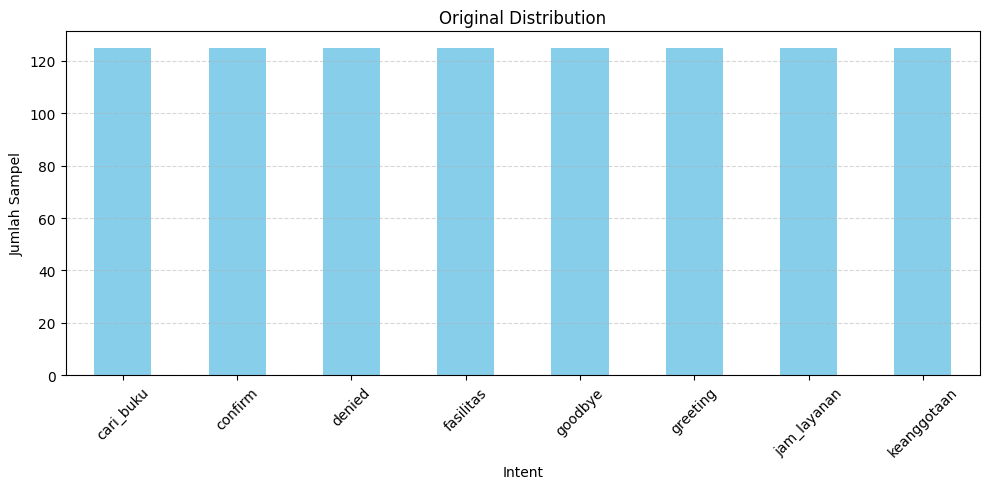

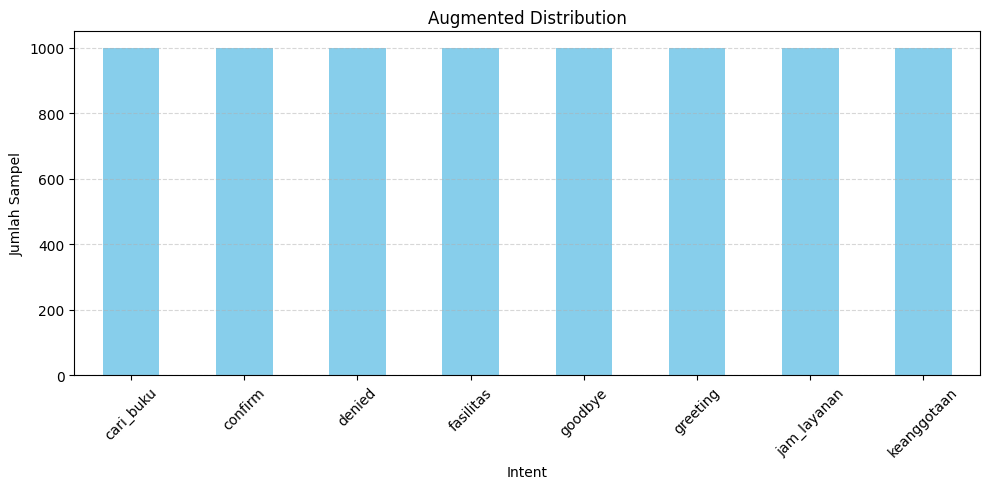


Summary:
  Original samples: 1000
  Final samples: 8000
  Added samples: 7000
  Augmentation ratio: 8.00x
  Processing time: 1091.80 seconds


In [4]:
# @title Dataset Augmentation for Indonesian NLP - Improved Version
import pandas as pd
import random
import re
import nltk
import torch
import time
import os
import json
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from deep_translator import GoogleTranslator
from collections import defaultdict, Counter
from tqdm import tqdm
import Levenshtein as lev  # For better text difference calculation

# Download WordNet data (if not already downloaded)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# =========[ KONFIGURASI ]=========
INPUT_FILE = "/content/ChatbotPerpusBipa/train.xlsx" # @param {"type":"string"}
DATA_TYPE = "train" # @param ["train", "val", "test"]
TARGET_SAMPLES_PER_CLASS = 1000    # @param {type:"integer"} Target jumlah sampel per kelas
NOISE_INTENSITY = 0.7             # @param {type:"number"} Control how aggressive augmentations are (0.1-1.0)
USE_PARAPHRASE_MODEL = True       # @param {type:"boolean"} Aktifkan atau matikan paraphrase
USE_BACK_TRANSLATION = True       # @param {type:"boolean"} Aktifkan atau matikan back-translation
MIN_AUGMENTATIONS_PER_SAMPLE = 2  # @param {type:"integer"} Minimum augmentasi per sampel asli
MAX_AUGMENTATIONS_PER_SAMPLE = 15  # @param {type:"integer"} Maximum augmentasi per sampel asli (reduced from 10)
BATCH_SIZE = 16                   # @param {type:"integer"} Untuk batch processing

def load_from_json(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return json.load(f)

def load_all_dictionaries():
    all_dicts = load_from_json('/content/ChatbotPerpusBipa/kamus.json')

    id_synonyms = all_dicts['id_synonyms']
    common_slang = all_dicts['common_slang']
    intent_slang = all_dicts['intent_slang']
    phonetic_dict = all_dicts['phonetic_dict']
    protected_intent_words = all_dicts['protected_intent_words']

    return id_synonyms, common_slang, intent_slang, phonetic_dict, protected_intent_words

# Option 2:
id_synonyms, common_slang, intent_slang, phonetic_dict, protected_intent_words = load_all_dictionaries()

# =========[ READ & VALIDATE FILE ]=========
def read_dataset(file_path):
    """Membaca dataset dari file CSV atau XLSX"""
    print(f"Loading dataset: {file_path}")

    file_ext = os.path.splitext(file_path)[1].lower()

    if file_ext == '.xlsx':
        print(f"Detected Excel file: {file_path}")
        df = pd.read_excel(file_path)
        # Konversi ke CSV untuk kompatibilitas
        csv_path = file_path.replace('.xlsx', '.csv')
        df.to_csv(csv_path, index=False)
        print(f"Converted Excel file to CSV: {csv_path}")
    elif file_ext == '.csv':
        print(f"Detected CSV file: {file_path}")
        df = pd.read_csv(file_path)
    else:
        raise ValueError(f"Format file tidak didukung: {file_ext}. Harap gunakan file CSV atau XLSX.")

    df = df.dropna()
    print(f"Dataset dimuat dengan {len(df)} baris")

    return df

# =========[ INITIALIZE PARAPHRASE MODEL IF NEEDED ]=========
def initialize_paraphrase_model():
    """Initialize paraphrase model if enabled"""
    if USE_PARAPHRASE_MODEL:
        print("Loading paraphrase model...")
        start_time = time.time()
        tokenizer = AutoTokenizer.from_pretrained("Wikidepia/IndoT5-base-paraphrase")
        model = AutoModelForSeq2SeqLM.from_pretrained("Wikidepia/IndoT5-base-paraphrase")

        # Move model to GPU if available
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        print(f"Model loaded in {time.time() - start_time:.2f} seconds. Using device: {device}")
        return model, tokenizer
    return None, None

# =========[ AUGMENTATION METHODS ]=========
def get_better_synonym(word):
    """Get synonym from custom dictionary or return the original word"""
    word_lower = word.lower()
    if word_lower in id_synonyms:
        synonyms = id_synonyms[word_lower]
        return random.choice(synonyms)
    return word

def replace_with_synonym(sentence):
    """Replace words with synonyms while preserving capitalization"""
    words = sentence.split()
    new_words = []

    # Limit the number of words to replace to avoid excessive changes
    num_to_replace = min(2, max(1, int(len(words) * 0.2)))
    indices_to_replace = random.sample(range(len(words)), k=min(num_to_replace, len(words)))

    for i, word in enumerate(words):
        if i in indices_to_replace:
            synonym = get_better_synonym(word)
            # Preserve capitalization
            if word and word[0].isupper() and synonym:
                synonym = synonym[0].upper() + synonym[1:]
            new_words.append(synonym)
        else:
            new_words.append(word)

    return " ".join(new_words)

def back_translate(sentence):
    """Translate to English and back to Indonesian with safety checks"""
    if not USE_BACK_TRANSLATION:
        return sentence

    # Skip very short sentences
    if len(sentence.split()) < 3:
        return sentence

    try:
        # First to English
        translated = GoogleTranslator(source='id', target='en').translate(sentence)
        # Then back to Indonesian
        back_translated = GoogleTranslator(source='en', target='id').translate(translated)

        # Safety checks
        if back_translated and len(back_translated.split()) >= len(sentence.split()) * 0.7:
            # Calculate how different the result is
            similarity = 1 - (lev.distance(sentence.lower(), back_translated.lower()) / max(len(sentence), len(back_translated)))
            # If too different or too similar, return original
            if similarity < 0.3 or similarity > 0.9:
                return sentence
            return back_translated
        return sentence
    except Exception:
        return sentence

def add_typo(sentence):
    """Add a single typo by replacing a character, with reduced probability"""
    # Skip for very short sentences or with low global noise setting
    if len(sentence) < 10 or random.random() > NOISE_INTENSITY:
        return sentence

    chars = list(sentence)
    if len(chars) > 3:
        # Try to find a good character to modify (not first or last character)
        candidates = [i for i in range(1, len(chars)-1) if chars[i].isalpha()]
        if candidates:
            idx = random.choice(candidates)
            # Get neighboring letters on keyboard for more realistic typos
            keyboard_neighbors = {
                'q': 'wsa', 'w': 'qeasd', 'e': 'wrsdf', 'r': 'etdfg',
                't': 'ryfgh', 'y': 'tughj', 'u': 'yihjk', 'i': 'uojkl',
                'o': 'ipkl', 'p': 'ol',
                'a': 'qwszx', 's': 'awedcxz', 'd': 'serfcvx', 'f': 'drtgvbc',
                'g': 'ftyhvbn', 'h': 'gyujbnm', 'j': 'huiknm', 'k': 'jiolm',
                'l': 'kop',
                'z': 'asx', 'x': 'zsdc', 'c': 'xdfv', 'v': 'cfgb',
                'b': 'vghn', 'n': 'bhjm', 'm': 'njk'
            }
            char = chars[idx].lower()
            if char in keyboard_neighbors:
                chars[idx] = random.choice(keyboard_neighbors[char])

    return "".join(chars)

def random_deletion(sentence, p=0.1):  # Reduced probability from 0.2
    """Delete words with probability p"""
    words = sentence.split()

    # Don't delete from short sentences
    if len(words) <= 4:
        return sentence

    # Don't delete too many words
    max_deletions = max(1, int(len(words) * 0.1))
    deletion_count = 0

    new_words = []
    for word in words:
        if random.uniform(0, 1) > p or deletion_count >= max_deletions:
            new_words.append(word)
        else:
            deletion_count += 1

    # Make sure we don't delete everything
    if not new_words:
        return sentence

    return " ".join(new_words)

def random_swap(sentence, n=1):
    """Swap n pairs of words"""
    words = sentence.split()
    if len(words) < 4:  # Don't swap in very short sentences
        return sentence

    # Limit swaps to just 1 for shorter sentences
    if len(words) < 8:
        n = 1

    for _ in range(min(n, len(words)//3)):  # Reduced number of swaps
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]

    return " ".join(words)

def phonetic_augmentation(sentence):
    """Apply phonetic substitutions common in Indonesian chat"""
    words = sentence.split()
    new_words = []

    # Limit substitutions to maintain readability
    max_substitutions = min(2, max(1, int(len(words) * 0.2)))
    substitution_count = 0

    for word in words:
        word_lower = word.lower()
        if word_lower in phonetic_dict and substitution_count < max_substitutions:
            new_word = random.choice(phonetic_dict[word_lower])
            # Preserve capitalization
            if word and word[0].isupper():
                new_word = new_word[0].upper() + new_word[1:]
            new_words.append(new_word)
            substitution_count += 1
        else:
            new_words.append(word)

    return " ".join(new_words)

def apply_slang_typo(text, intent, intensity=1.0):
    """Apply slang replacements with controllable intensity"""
    # Combine common slang with intent-specific slang
    slang_dict = common_slang.copy()
    if intent in intent_slang:
        slang_dict.update(intent_slang[intent])

    # Create regex patterns from the slang dictionary
    patterns = {
        re.compile(rf'\b{k}\b', re.IGNORECASE): v for k, v in slang_dict.items()
    }

    # Apply only a few patterns based on intensity and text length
    max_replacements = min(2, max(1, int(len(text.split()) * 0.2)))
    patterns_to_use = random.sample(
        list(patterns.items()),
        k=min(max_replacements, int(len(patterns) * min(0.3, intensity * 0.5)))
    )

    for pattern, replacement in patterns_to_use:
        text = pattern.sub(replacement, text)

    return text

def character_noise(text, intensity=1.0):
    """Add typos like character swaps, insertions, deletions with reduced intensity"""
    # Skip for very short texts
    if len(text) < 10 or random.random() > NOISE_INTENSITY:
        return text

    chars = list(text)
    # Significantly reduce swap probability
    swap_prob = min(0.03, intensity * 0.01)  # Lower from 0.1 to 0.03

    # Limit to just one or two swaps per sentence
    max_swaps = min(1, int(len(chars) * 0.05))
    swap_count = 0

    for i in range(len(chars)-1):
        if random.random() < swap_prob and swap_count < max_swaps:
            # Don't swap punctuation or spaces
            if chars[i].isalpha() and chars[i+1].isalpha():
                chars[i], chars[i+1] = chars[i+1], chars[i]
                swap_count += 1

    return ''.join(chars)

def add_common_phrase(sentence):
    """Add a common Indonesian chat phrase"""
    # Skip for longer sentences
    if len(sentence.split()) > 8:
        return sentence

    common_phrases = ["sih", "ya", "dong", "cuy", "bro", "lah", "deh"]
    return sentence + " " + random.choice(common_phrases)

def short_text_augmentation(text, intent):
    """Special augmentation for very short texts like greetings and goodbyes"""
    # For very short texts, add filler words or expressions
    fillers = {
        'greeting': ['', ' ya', ' kak', ' min', ' gan', ' bro', ' sis', ' admin', '!'],
        'goodbye': ['', ' ya', ' kak', ' min', ' semuanya', '!'],
        'confirm': ['', ' kok', ' dong', ' banget', ' sih', ' tentu', ' lah', '!'],
        'denied': ['', ' sih', ' kok', ' ah', ' deh', ' lah', '!'],
    }

    if intent in fillers and len(text.split()) <= 3:
        # Add just one filler
        if random.random() < 0.7:  # 70% chance to add filler
            text += random.choice(fillers[intent])

    return text

def validate_augmentation(original, augmented):
    """Validate if augmentation is reasonable with stricter requirements"""
    # Skip if no change
    if augmented.lower() == original.lower():
        return False

    # Calculate word count difference
    orig_words = original.split()
    aug_words = augmented.split()

    # Check if length is reasonable
    if len(aug_words) < len(orig_words) * 0.6 or len(aug_words) > len(orig_words) * 1.4:
        return False

    # Calculate text similarity using Levenshtein distance
    normalized_distance = lev.distance(original.lower(), augmented.lower()) / max(len(original), len(augmented))
    # If too similar or too different, reject
    if normalized_distance < 0.03 or normalized_distance > 0.5:
        return False

    # Check for excessive non-standard characters
    non_indo_pattern = re.compile(r'[^a-zA-Z0-9\s.,?!\'"-:;()[\]{}]')
    if len(non_indo_pattern.findall(augmented)) > 3:
        return False

    # Check if individual words have been mangled too much
    if len(orig_words) == len(aug_words):
        word_changes = 0
        for i in range(len(orig_words)):
            # Check word edit distance
            if len(orig_words[i]) > 3 and lev.distance(orig_words[i], aug_words[i]) > len(orig_words[i]) * 0.5:
                word_changes += 1

        # Reject if too many words changed significantly
        if word_changes / len(orig_words) > 0.4:
            return False

    return True

def batch_paraphrase(model, tokenizer, sentences, batch_size=BATCH_SIZE):
    """Process paraphrasing in batches"""
    if not sentences or model is None or tokenizer is None:
        return []

    device = next(model.parameters()).device
    results = []

    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        inputs = tokenizer(["paraphrase: " + text + " </s>" for text in batch],
                         padding='longest', truncation=True, max_length=128,
                         return_tensors="pt").to(device)

        with torch.no_grad():  # Disable gradient calculation for inference
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=128,
                do_sample=True,
                top_k=200,  # Reduce from 200 to 120 for more conservative output
                top_p=0.98,
                temperature=NOISE_INTENSITY + 0.3, # Added temperature control
                early_stopping=False,
                num_return_sequences=min(3, BATCH_SIZE // len(batch))
            )

        decoded = [tokenizer.decode(outputs[j], skip_special_tokens=True)
                  for j in range(len(outputs))]
        results.extend(decoded)

    return results

# Combined augmentation strategies
def augment_text(text, intent, intensity=1.0):
    """Apply multiple augmentation techniques based on class needs"""
    # Scale intensity by global noise setting
    intensity = intensity * NOISE_INTENSITY

    # Protect intent-critical words
    protected = []
    if intent in protected_intent_words:
        for word in protected_intent_words[intent]:
            pattern = re.compile(rf'\b{word}\b', re.IGNORECASE)
            for match in pattern.finditer(text):
                # Replace with a temporary placeholder
                placeholder = f"__PROTECTED_{len(protected)}__"
                text = text[:match.start()] + placeholder + text[match.end():]
                protected.append((placeholder, match.group(0)))

    # Available methods - reorder by safety
    methods = {
        'synonym': replace_with_synonym,          # Safe
        'back_translate': back_translate if USE_BACK_TRANSLATION else None,  # Generally safe
        'slang': lambda t: apply_slang_typo(t, intent, intensity), # Safe if using known slang
        'common_phrase': add_common_phrase,       # Safe
        'short_text': lambda t: short_text_augmentation(t, intent), # Safe
        'swap': random_swap,                      # Moderately safe
        'deletion': random_deletion,              # Can be problematic
        'phonetic': phonetic_augmentation,        # Can be problematic
        'char_noise': lambda t: character_noise(t, intensity * 0.5),  # Reduced intensity
        'typo': add_typo                          # Most problematic
    }

    # Remove None methods
    methods = {k: v for k, v in methods.items() if v is not None}

    # Choose augmentation methods based on text length and intent
    text_length = len(text.split())

    if text_length <= 3:  # Very short text
        # For short texts, focus on safer methods
        method_choices = ['slang', 'short_text', 'synonym', 'common_phrase']
        num_methods = min(2, int(intensity * 2))  # Reduce number of transformations
    else:  # Longer text
        # Weight safer methods higher in the selection
        method_choices = ['synonym', 'synonym', 'back_translate', 'slang', 'slang',
                          'common_phrase', 'swap', 'deletion', 'phonetic', 'char_noise']
        # Apply fewer transformations overall
        num_methods = min(2, int(intensity * 1.5))

    # Filter out any methods that aren't available (like back_translate if disabled)
    method_choices = [m for m in method_choices if m in methods]

    # Sample methods
    if method_choices:
        selected_methods = random.sample(method_choices, k=min(num_methods, len(method_choices)))
    else:
        selected_methods = []

    # Apply selected methods in sequence
    result = text
    for method_name in selected_methods:
        if method_name in methods:
            method = methods[method_name]
            result = method(result)

    # Restore protected words
    for placeholder, original in protected:
        result = result.replace(placeholder, original)

    return result

def augment_data(text, intent):
    """Generate multiple augmentations for a text"""
    methods = [
        replace_with_synonym,
        back_translate if USE_BACK_TRANSLATION else None,
        lambda t: augment_text(t, intent, 1.0)  # Use combined approach
    ]

    # Remove None methods
    methods = [m for m in methods if m is not None]

    augmented = set()
    for method in methods:
        try:
            result = method(text)
            if validate_augmentation(text, result):
                augmented.add(result)
        except Exception as e:
            print(f"Error applying {method.__name__}: {str(e)}")
            continue

    return list(augmented)

def balance_samples(results_by_intent, target_samples_per_class, original_counts):
    """
    Balance samples by intent with preference toward reaching TARGET_SAMPLES_PER_CLASS
    """
    balanced_results = defaultdict(list)

    for intent, samples in results_by_intent.items():
        orig_count = original_counts.get(intent, 0)
        current_count = len(samples)

        # Keep all original data
        original_data = samples[:orig_count]
        balanced_results[intent].extend(original_data)

        # Get augmented samples (everything after original data)
        augmented_data = samples[orig_count:]

        # Calculate how many we need
        remaining_slots = target_samples_per_class - orig_count

        if remaining_slots > 0:
            # If we have enough augmented samples
            if len(augmented_data) >= remaining_slots:
                # Randomize selection
                random.shuffle(augmented_data)
                # Add what we need
                balanced_results[intent].extend(augmented_data[:remaining_slots])
            else:
                # If we don't have enough, add all augmented samples
                balanced_results[intent].extend(augmented_data)
                # And duplicate some if needed (to reach closer to target)
                shortage = remaining_slots - len(augmented_data)
                if shortage > 0 and len(augmented_data) > 0:
                    # Add duplicates of existing augmentations to help reach target
                    extras = random.choices(augmented_data, k=min(shortage, len(augmented_data) * 2))
                    balanced_results[intent].extend(extras)

    return balanced_results

def plot_distribution(data, title):
    """Plot distribution of samples by intent"""
    plt.figure(figsize=(10, 5))
    data['intent'].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel("Intent")
    plt.ylabel("Jumlah Sampel")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# =========[ MAIN PROCESS ]=========
def main():
    """Main process for dataset augmentation"""
    # Set up file paths based on chosen data type
    if DATA_TYPE == "train":
        OUTPUT_FILE = "train.csv"
        input_file = INPUT_FILE
        output_file = OUTPUT_FILE
    elif DATA_TYPE == "val":
        # If different paths needed for validation
        OUTPUT_FILE = "val.csv"
        input_file = INPUT_FILE.replace("train", "val")
        output_file = OUTPUT_FILE.replace("train", "val")
    elif DATA_TYPE == "test":
        # If different paths needed for test
        OUTPUT_FILE = "test.csv"
        input_file = INPUT_FILE.replace("train", "test")
        output_file = OUTPUT_FILE.replace("train", "test")
    else:
        input_file = INPUT_FILE
        output_file = OUTPUT_FILE

    # Read the dataset
    df = read_dataset(input_file)

    # Initialize paraphrase model if enabled
    model, tokenizer = initialize_paraphrase_model()

    # Count original samples per intent
    intent_counts = Counter(df['intent'])
    print("Original class distribution:")
    for intent, count in intent_counts.items():
        print(f"  {intent}: {count}")

    # Calculate augmentation factors for balancing
    augmentation_factors = {}
    for intent, count in intent_counts.items():
        if count >= TARGET_SAMPLES_PER_CLASS:
            augmentation_factors[intent] = 1  # Minimum factor
        else:
            factor = max(1, min(10, TARGET_SAMPLES_PER_CLASS / count))  # Reduced max factor from 10 to 5
            augmentation_factors[intent] = factor

    print("\nAugmentation factors:")
    for intent, factor in augmentation_factors.items():
        print(f"  {intent}: {factor:.2f}x")

    # Start augmentation process
    print("Starting balanced augmentation...")
    start_time = time.time()

    augmented_results = defaultdict(list)
    paraphrase_candidates = defaultdict(list)

    # First, add all original data
    for _, row in df.iterrows():
        intent = row['intent']
        text = row['text']
        augmented_results[intent].append(text)

    # Then determine augmentation targets for each intent
    for intent, factor in augmentation_factors.items():
        original_count = intent_counts[intent]
        intent_df = df[df['intent'] == intent]

        for _, row in tqdm(intent_df.iterrows(), desc=f"Augmenting '{intent}'", total=len(intent_df)):
            text = row['text']

            # Calculate needed augmentations for this sample
            num_augmentations = max(
                MIN_AUGMENTATIONS_PER_SAMPLE,
                min(MAX_AUGMENTATIONS_PER_SAMPLE, int(factor * 2.0))  # Reduced multiplier from 2 to 1.5
            )

            # Regular augmentations
            attempts = 0
            augmentations_created = 0

            while augmentations_created < num_augmentations and attempts < num_augmentations * 4:
                attempts += 1
                # More conservative intensity calculation
                intensity = min(1.0, NOISE_INTENSITY + (factor - 1) * 0.2)  # Use NOISE_INTENSITY directly
                aug_text = augment_text(text, intent, intensity)


                if aug_text.lower() != text.lower() and validate_augmentation(text, aug_text):
                    augmented_results[intent].append(aug_text)
                    augmentations_created += 1

            # For paraphrase model processing (batch later)
            if USE_PARAPHRASE_MODEL and augmentations_created < num_augmentations:
                paraphrase_candidates[intent].append(text)

    # Batch paraphrase additional samples if needed
    if USE_PARAPHRASE_MODEL and model is not None:
        print("\nApplying paraphrase model in batches...")

        for intent, texts in paraphrase_candidates.items():
            # Skip intents that already have enough samples
            if len(augmented_results[intent]) >= TARGET_SAMPLES_PER_CLASS:
                continue

            print(f"  Processing {len(texts)} texts for intent '{intent}'")

            needed = TARGET_SAMPLES_PER_CLASS - len(augmented_results[intent])
            # Process only what we need with a small buffer
            process_count = min(len(texts), needed * 2)

            # Get a random sample if there are many candidates
            if len(texts) > process_count:
                texts_to_process = random.sample(texts, process_count)
            else:
                texts_to_process = texts

            # Process in batches
            paraphrased = batch_paraphrase(model, tokenizer, texts_to_process, BATCH_SIZE)

            # Add valid paraphrases
            valid_count = 0
            for orig, para in zip(texts_to_process, paraphrased):
                if validate_augmentation(orig, para):
                    augmented_results[intent].append(para)
                    valid_count += 1

                    # Stop if we have enough
                    if len(augmented_results[intent]) >= TARGET_SAMPLES_PER_CLASS:
                        break

            print(f"    Added {valid_count} valid paraphrases")

    # Balance the data
    print("Balancing final dataset...")
    balanced_data = balance_samples(augmented_results, TARGET_SAMPLES_PER_CLASS, intent_counts)
    # After all augmentation is done, check if classes are balanced
    min_class_size = min(len(samples) for samples in balanced_data.values())

    # If classes are not balanced, downsample the larger classes
    for intent in balanced_data:
        if len(balanced_data[intent]) > min_class_size:
            # Keep all original data
            orig_count = intent_counts.get(intent, 0)
            original_data = balanced_data[intent][:orig_count]
            augmented_data = balanced_data[intent][orig_count:]

            # Randomly select augmented data to keep
            needed = min_class_size - orig_count
            if needed > 0 and augmented_data:
                random.shuffle(augmented_data)
                balanced_data[intent] = original_data + augmented_data[:needed]
            else:
                balanced_data[intent] = original_data[:min_class_size]
    # Create final balanced dataframe
    rows = []
    for intent, texts in balanced_data.items():
        for text in texts:
            rows.append({"intent": intent, "text": text})

    final_df = pd.DataFrame(rows)

    # Print final statistics
    print("\nFinal dataset statistics:")
    final_counts = Counter(final_df['intent'])
    for intent, count in final_counts.items():
        orig = intent_counts.get(intent, 0)
        added = count - orig
        print(f"  {intent}: {count} total ({orig} original + {added} augmented)")

    # Save to file
    final_df.to_csv(output_file, index=False)
    print(f"\nSaved balanced dataset to {output_file}")

    # Plot distributions
    try:
        print("Plotting class distributions...")
        plot_distribution(df, "Original Distribution")
        plot_distribution(final_df, "Augmented Distribution")
    except Exception as e:
        print(f"Error plotting distributions: {e}")

    # Calculate statistics
    original_total = len(df)
    augmented_total = len(final_df)
    time_taken = time.time() - start_time

    print(f"\nSummary:")
    print(f"  Original samples: {original_total}")
    print(f"  Final samples: {augmented_total}")
    print(f"  Added samples: {augmented_total - original_total}")
    print(f"  Augmentation ratio: {augmented_total / original_total:.2f}x")
    print(f"  Processing time: {time_taken:.2f} seconds")


if __name__ == "__main__":
    main()

In [5]:
# @title hapus duplikat
import pandas as pd
inputdataset = "train.csv" # @param {"type":"string"}
outputdataset = "trainclean.csv" # @param {"type":"string"}
try:
    df = pd.read_csv(inputdataset)
except FileNotFoundError:
    print("Error: train.csv not found. Please upload the file to the Colab environment.")
    exit()

# Remove duplicates based on 'text' and 'intent' columns, keeping the first occurrence
df_deduplicated = df.drop_duplicates(subset=['text', 'intent'], keep='first')

# Print the shape of the original and deduplicated DataFrames
print(f"Original DataFrame shape: {df.shape}")
print(f"Deduplicated DataFrame shape: {df_deduplicated.shape}")

# Print the deduplicated DataFrame (optional)
df_deduplicated

# Save the deduplicated DataFrame to a new CSV file (optional)
df_deduplicated.to_csv(outputdataset, index=False)
print(f"Number of rows before removing duplicates: {len(df)}")
print(f"Number of rows after removing duplicates: {len(df_deduplicated)}")

# Display the intent distribution
intent_distribution = df_deduplicated['intent'].value_counts()
print("\nIntent Distribution:")
intent_distribution


Original DataFrame shape: (8000, 2)
Deduplicated DataFrame shape: (6152, 2)
Number of rows before removing duplicates: 8000
Number of rows after removing duplicates: 6152

Intent Distribution:


,count
intent,
keanggotaan,869
fasilitas,855
cari_buku,829
jam_layanan,803
goodbye,735
denied,732
confirm,665
greeting,664


In [ ]:
# @title test
import torch
import os
import json
import pickle
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import IPython.display as display
from IPython.display import HTML, display

# Mount Google Drive
drive.mount('/content/drive')

class IntentPredictor:
    """Class for intent prediction with OOD detection for Google Colab"""

    def __init__(self, model_path, mount_drive=True):
        """Initialize the predictor with a trained model path"""
        if mount_drive and not os.path.exists('/content/drive'):
            print("Mounting Google Drive...")
            drive.mount('/content/drive')

        self.model_path = model_path
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        print(f"Loading model from {model_path}...")
        print(f"Using device: {self.device}")

        # Load model and tokenizer
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model.to(self.device)
        self.model.eval()

        # Load intent classes and label encoder
        with open(os.path.join(model_path, "intent_classes.pkl"), "rb") as f:
            self.intent_classes = pickle.load(f)

        with open(os.path.join(model_path, "label_encoder.pkl"), "rb") as f:
            self.label_encoder = pickle.load(f)

        # Load OOD thresholds
        self.thresholds = self.load_ood_thresholds()

        print(f"Model loaded successfully. Detected {len(self.intent_classes)} intents.")
        print(f"Supported intents: {', '.join(self.intent_classes)}")
        print(f"OOD thresholds: Energy={self.thresholds['energy_threshold']:.4f}, MSP={self.thresholds['msp_threshold']:.4f}")

    def load_ood_thresholds(self):
        """Load OOD detection thresholds from file"""
        try:
            with open(os.path.join(self.model_path, "ood_thresholds.json"), 'r') as f:
                thresholds = json.load(f)
                return thresholds
        except FileNotFoundError:
            try:
                with open(os.path.join(self.model_path, "ood_threshold.json"), 'r') as f:
                    threshold_data = json.load(f)
                    return {
                        "energy_threshold": threshold_data["energy_threshold"],
                        "msp_threshold": 0.5  # Default value
                    }
            except FileNotFoundError:
                print("Warning: OOD threshold files not found. Using default thresholds.")
                return {
                    "energy_threshold": 0.0,
                    "msp_threshold": 0.5
                }

    def predict(self, text, temperature=1.0):
        """Predict intent for a single text with OOD detection"""
        # Tokenize input
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )

        # Move inputs to device
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Get model output
        with torch.no_grad():
            outputs = self.model(**inputs)

        logits = outputs.logits

        # Calculate energy score for OOD detection
        energy = -temperature * torch.logsumexp(logits / temperature, dim=1)
        energy_score = energy.item()

        # Calculate maximum softmax probability
        softmax_probs = F.softmax(logits, dim=1)
        max_prob, prediction = torch.max(softmax_probs, dim=1)
        max_prob = max_prob.item()
        prediction = prediction.item()

        # Get predicted intent
        intent = self.intent_classes[prediction]

        # Get all probabilities with intent names
        all_probs = softmax_probs[0].cpu().numpy()
        intent_probs = {self.intent_classes[i]: float(all_probs[i]) for i in range(len(self.intent_classes))}

        # Determine if sample is OOD using both methods
        is_ood_energy = energy_score > self.thresholds["energy_threshold"]
        is_ood_msp = max_prob < self.thresholds["msp_threshold"]

        # Use either one or both methods for final OOD decision
        # Here we're using energy method as primary, MSP as secondary validation
        is_ood = is_ood_energy or is_ood_msp

        # Return full prediction results
        result = {
            "text": text,
            "intent": intent,
            "is_ood": is_ood,
            "confidence": max_prob,
            "energy_score": energy_score,
            "intent_probabilities": intent_probs,
            "ood_details": {
                "is_ood_energy": is_ood_energy,
                "is_ood_msp": is_ood_msp,
                "energy_threshold": self.thresholds["energy_threshold"],
                "msp_threshold": self.thresholds["msp_threshold"]
            }
        }

        return result

    def predict_batch(self, texts):
        """Predict intents for a batch of texts"""
        results = []
        for text in tqdm(texts, desc="Predicting intents"):
            results.append(self.predict(text))
        return results

    def predict_csv(self, csv_path, text_column="text", save_path=None):
        """Predict intents for texts in a CSV file and optionally save results"""
        # Read CSV
        df = pd.read_csv(csv_path)

        if text_column not in df.columns:
            raise ValueError(f"Column '{text_column}' not found in CSV")

        # Make predictions
        texts = df[text_column].tolist()
        results = self.predict_batch(texts)

        # Create results dataframe
        results_df = pd.DataFrame(results)

        # Merge with original data if needed
        if len(df.columns) > 1:
            df['predicted_intent'] = results_df['intent']
            df['confidence'] = results_df['confidence']
            df['is_ood'] = results_df['is_ood']
            output_df = df
        else:
            output_df = results_df

        # Save results if path is provided
        if save_path:
            output_df.to_csv(save_path, index=False)
            print(f"Prediction results saved to {save_path}")

        return output_df

    def display_prediction_results(self, result, show_top_n=3):
        """Display prediction results in a formatted way in Google Colab"""
        display(HTML(f"""
        <div style="background-color: #f5f5f5; padding: 15px; border-radius: 10px; margin-bottom: 20px;">
            <h3 style="margin-top: 0; color: #333;">Prediction Results</h3>
            <p><b>Text:</b> {result['text']}</p>
            <p><b>Predicted Intent:</b> <span style="color: #4285F4; font-weight: bold;">{result['intent']}</span></p>
            <p><b>Confidence:</b> {result['confidence']:.4f}</p>

            <div style="margin-top: 10px;">
                <b>Status:</b>
                <span style="color: {'#DB4437' if result['is_ood'] else '#0F9D58'}; font-weight: bold;">
                    {'OUT-OF-DISTRIBUTION' if result['is_ood'] else 'In-distribution'}
                </span>
            </div>

            <div style="margin-top: 15px;">
                <b>OOD Detection Details:</b>
                <ul>
                    <li>Energy Score: {result['energy_score']:.4f} (Threshold: {result['ood_details']['energy_threshold']:.4f})</li>
                    <li>MSP Score: {result['confidence']:.4f} (Threshold: {result['ood_details']['msp_threshold']:.4f})</li>
                </ul>
            </div>
        </div>
        """))

        # Plot top intent probabilities
        top_intents = sorted(result['intent_probabilities'].items(), key=lambda x: x[1], reverse=True)[:show_top_n]
        labels = [intent for intent, _ in top_intents]
        values = [prob for _, prob in top_intents]

        plt.figure(figsize=(10, 5))
        bars = plt.bar(labels, values, color='skyblue')
        plt.title('Top Intent Probabilities')
        plt.xlabel('Intent')
        plt.ylabel('Probability')
        plt.ylim(0, 1)
        plt.xticks(rotation=45, ha='right')

        # Add value labels
        for bar, value in zip(bars, values):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.4f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, true_intents, predicted_intents):
        """Plot confusion matrix for batch predictions"""
        from sklearn.metrics import confusion_matrix

        # Get unique intents
        unique_intents = list(set(true_intents + predicted_intents))

        # Create confusion matrix
        cm = confusion_matrix(true_intents, predicted_intents, labels=unique_intents)

        # Plot
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=unique_intents, yticklabels=unique_intents)
        plt.title('Confusion Matrix')
        plt.ylabel('True Intent')
        plt.xlabel('Predicted Intent')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Function to demonstrate usage with sample texts
def demo_predictor(model_path, sample_texts=None):
    """Demonstrate the intent predictor with sample texts"""
    predictor = IntentPredictor(model_path)

    # Use default samples if none provided
    if sample_texts is None:
        sample_texts = [
            "Tolong jelaskan cara membeli tiket",
            "Bagaimana cara mendaftar akun?",
            "Saya ingin membatalkan pesanan saya",
            "kjhgfdtyuiolkjhgfdsdfghjkl",  # Gibberish text to test OOD
            "What is the weather like today?"  # English text to test OOD
        ]

    print("\nPredicting sample texts:")
    for text in sample_texts:
        result = predictor.predict(text)
        predictor.display_prediction_results(result)

# Google Colab-specific interactive demo with widgets
def interactive_demo(model_path):
    """Interactive demo using Colab widgets"""
    from ipywidgets import widgets
    from IPython.display import display, clear_output

    predictor = IntentPredictor(model_path)

    # Create text input widget
    text_input = widgets.Text(
        value='',
        placeholder='Type your text here',
        description='Input:',
        disabled=False,
        layout=widgets.Layout(width='70%')
    )

    # Create predict button
    predict_button = widgets.Button(
        description='Predict',
        disabled=False,
        button_style='primary',
        tooltip='Click to predict intent',
        icon='check'
    )

    output = widgets.Output()

    # Define button click handler
    def on_button_clicked(b):
        with output:
            clear_output()
            if text_input.value.strip():
                result = predictor.predict(text_input.value)
                predictor.display_prediction_results(result)
            else:
                print("Please enter some text to predict.")

    predict_button.on_click(on_button_clicked)

    # Display widgets
    display(HTML('<h2>Intent Prediction Demo</h2>'))
    display(widgets.HBox([text_input, predict_button]))
    display(output)

# Run prediction from a CSV file including visualization
def predict_from_csv(model_path, csv_path, text_column="text", label_column=None, output_path=None):
    """Run predictions on a CSV file with visualization"""
    predictor = IntentPredictor(model_path)

    # Load CSV
    df = pd.read_csv(csv_path)
    texts = df[text_column].tolist()

    # Make predictions
    results = predictor.predict_batch(texts)

    # Create results dataframe
    results_df = pd.DataFrame(results)

    # Merge with original data
    df['predicted_intent'] = results_df['intent']
    df['confidence'] = results_df['confidence']
    df['is_ood'] = results_df['is_ood']

    # Save if output path specified
    if output_path:
        df.to_csv(output_path, index=False)
        print(f"Results saved to {output_path}")

    # Display summary
    print(f"Total predictions: {len(texts)}")
    print(f"In-distribution: {(~df['is_ood']).sum()} ({(~df['is_ood']).mean()*100:.2f}%)")
    print(f"Out-of-distribution: {df['is_ood'].sum()} ({df['is_ood'].mean()*100:.2f}%)")

    # Visualize intent distribution
    plt.figure(figsize=(12, 6))
    intent_counts = df['predicted_intent'].value_counts()
    sns.barplot(x=intent_counts.index, y=intent_counts.values)
    plt.title('Predicted Intent Distribution')
    plt.xlabel('Intent')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot confusion matrix if ground truth available
    if label_column and label_column in df.columns:
        predictor.plot_confusion_matrix(
            df[label_column].tolist(),
            df['predicted_intent'].tolist()
        )

    return df

# Main execution for Google Colab
# This function is designed to be the main entry point for the colab notebook
def run_predictor_colab():
    print("Intent Prediction with OOD Detection")
    print("====================================")

    # Path to the model - adjust as needed
    model_base_path = "/content/drive/MyDrive/models"

    # Check if models directory exists
    if not os.path.exists(model_base_path):
        print(f"Warning: Models directory {model_base_path} not found.")
        # Ask user to provide model path
        model_base_path = input("Enter path to models directory: ")

    # Get list of available models
    available_models = [d for d in os.listdir(model_base_path)
                      if os.path.isdir(os.path.join(model_base_path, d))]

    if not available_models:
        print("No model directories found. Please provide a path to a model directory.")
        model_path = input("Enter path to model: ")
    else:
        print("\nAvailable models:")
        for i, model in enumerate(available_models):
            print(f"{i+1}. {model}")

        model_idx = int(input("\nSelect a model by number: ")) - 1
        model_path = os.path.join(model_base_path, available_models[model_idx])

    print(f"\nUsing model at {model_path}")

    # Create predictor
    predictor = IntentPredictor(model_path)

    # Choose mode
    print("\nSelect operation mode:")
    print("1. Interactive Demo (with widgets)")
    print("2. Predict from CSV")
    print("3. Demo with sample texts")
    print("4. Predict a single text")

    mode = int(input("\nEnter mode number: "))

    if mode == 1:
        interactive_demo(model_path)
    elif mode == 2:
        csv_path = input("Enter path to CSV file: ")
        text_column = input("Enter text column name (default: 'text'): ") or "text"
        label_column = input("Enter ground truth column name (optional, for confusion matrix): ")
        if not label_column.strip():
            label_column = None
        output_path = input("Enter output CSV path (optional): ")
        if not output_path.strip():
            output_path = None
        predict_from_csv(model_path, csv_path, text_column, label_column, output_path)
    elif mode == 3:
        demo_predictor(model_path)
    elif mode == 4:
        while True:
            text = input("\nEnter text to predict (or 'quit' to exit): ")
            if text.lower() == 'quit':
                break
            result = predictor.predict(text)
            predictor.display_prediction_results(result)
    else:
        print("Invalid mode selected.")

# Code to run directly in Google Colab
if __name__ == "__main__":
    run_predictor_colab()



# Copy and paste the entire code from above

# Run the interactive demo
run_predictor_colab()

# Alternatively, you can directly use the predictor:
MODEL_PATH = "/content/drive/MyDrive/models/your_model_name"
predictor = IntentPredictor(MODEL_PATH)

# Predict a single text
result = predictor.predict("Bagaimana cara mendaftar akun?")
predictor.display_prediction_results(result)

# Or predict from a CSV file
df = predict_from_csv(MODEL_PATH, "/content/drive/MyDrive/data.csv", "text_column")